In [1]:
import os 
os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

# Define undriven system using scqubits, then convert to qiskit

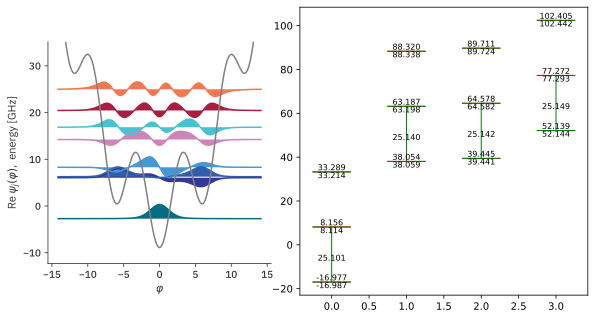

In [54]:
EJ=8.9
EC=2.5
EL=0.5
g_strength = 0.3
E_osc = 4
qubit_level = 4
osc_level = 7

from utils import *

qbt = scqubits.Fluxonium(EJ=EJ,EC=EC,EL=EL,flux=0,cutoff=30,truncated_dim=qubit_level)
osc = scqubits.Oscillator(E_osc=E_osc,truncated_dim=osc_level)
hilbertspace = scqubits.HilbertSpace([qbt, osc])
hilbertspace.add_interaction(g_strength=g_strength,op1=qbt.n_operator,op2=osc.creation_operator,add_hc=True)
hilbertspace.generate_lookup()
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())
# plot_specturum(qbt, osc, hilbertspace)

In [44]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver


def qobj_to_operator(matrix):
    if type(matrix) == qutip.qobj.Qobj:
        matrix = matrix.full()
    return Operator(matrix, input_dims = (matrix.shape[0],),output_dims = (matrix.shape[1],))

(evals,) = hilbertspace["evals"]
diag_matrix = np.diag(evals)
static_hamiltonian = 2 * np.pi * qobj_to_operator(diag_matrix)


In [143]:
leakage_dressed_state_osc_0 = product_to_dressed[(0,0)]
leakage_dressed_state_osc_1 = product_to_dressed[(0,1)]

tot_time = 50
# base_drive_amplitude = 1/tot_time
# matrix_element_driven = abs((a+a.dag()).data.toarray()[leakage_dressed_state_osc_0][leakage_dressed_state_osc_1])
# base_drive_amplitude = base_drive_amplitude/matrix_element_driven * 10

base_drive_amplitude = 0.05*2*np.pi

a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
driven_operator = 2 * np.pi * base_drive_amplitude * (qobj_to_operator(a)+qobj_to_operator(a.dag()))

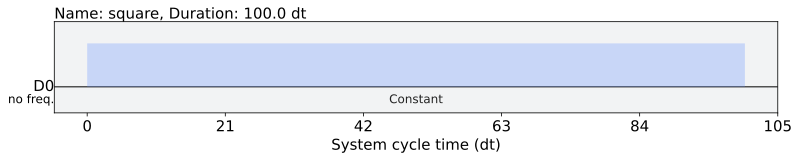

In [144]:
from qiskit_dynamics.array import Array
from qiskit_dynamics.signals.transfer_functions import BaseTransferFunction
from qiskit_dynamics.signals import Signal
from typing import Callable


w_d = transition_frequency(hilbertspace,leakage_dressed_state_osc_0,leakage_dressed_state_osc_1 )
carrier_freq = w_d * 2 * np.pi

import sympy as sym
from qiskit import pulse


signal_sample_dt = 0.5 # Sample rate of the backend in ns.


with pulse.build(name="square") as square:
    pulse.play(pulse.Constant(duration = int(tot_time/signal_sample_dt), amp = base_drive_amplitude), pulse.DriveChannel(0))

square.draw()


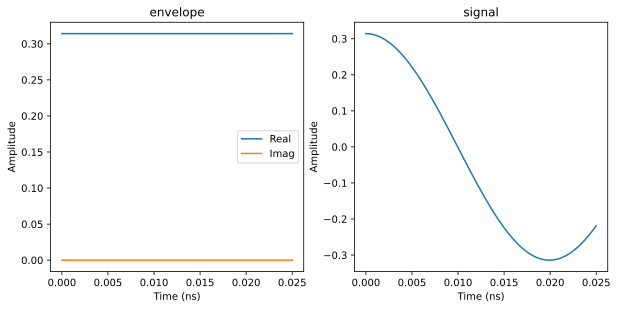

In [151]:
from qiskit_dynamics.pulse import InstructionToSignals
converter = InstructionToSignals(signal_sample_dt, carriers={"d0": carrier_freq})
signals = converter.get_signals(square)
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, tot_time/2000, 20000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)


In [146]:
ham_solver = Solver(
    hamiltonian_operators=[driven_operator],
    static_hamiltonian=static_hamiltonian,
    # rotating_frame=static_hamiltonian,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w_d},
    dt=signal_sample_dt
)

In [147]:
import jax.numpy as jnp
tot_dims = a.shape[0]
g0 = jnp.zeros(tot_dims).at[product_to_dressed[(0, 0)]].set(1).reshape(-1, 1)
e0 = jnp.zeros(tot_dims).at[product_to_dressed[(1, 0)]].set(1).reshape(-1, 1)
f0 = jnp.zeros(tot_dims).at[product_to_dressed[(2, 0)]].set(1).reshape(-1, 1)
h0 = jnp.zeros(tot_dims).at[product_to_dressed[(3, 0)]].set(1).reshape(-1, 1)

pn_op = jnp.array((a.dag()*a).full())
a_op = jnp.array(a.full())


In [148]:
tlist =  jnp.linspace(0,tot_time, int(tot_time)*2)

from qiskit_dynamics.pulse import InstructionToSignals

results = []
for y0 in [g0,e0,f0,h0]:
    result = ham_solver.solve(
        y0=y0,
        t_span=[0, tot_time],
        signals=square,
        method='jax_odeint',
        t_eval = tlist,
        atol=1e-8,
        rtol=1e-8
    )#[0]
    results.append(result)

In [161]:
product_states = [(ql,ol) for ql in range(qubit_level) for ol in range(osc_level)]
idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]

nlevels = 4
from jax import vmap

def compute_expectation(ket, operator):
    return (jnp.linalg.multi_dot([jnp.conj(ket).T, operator, ket]))[0][0]

# Vectorize the function over the kets
vectorized_compute_expectation = vmap(compute_expectation, in_axes=(0, None))

for i in range(nlevels):
    if hasattr(results[i], 'y'):
        states = jnp.array(results[i].y)  # assuming y contains JAX arrays
    elif hasattr(results[i], 'states'):
        states = jnp.stack([jnp.array(q.full()) for q in results[i].states])  # assuming states contains QObj

    results[i].expect = []
    for idx in idxs:
        dressed_state = jnp.zeros(tot_dims).at[idx].set(1).reshape(-1, 1)
        dressed_state_op = jnp.outer(dressed_state, jnp.conj(dressed_state).T)
        expectations = vectorized_compute_expectation(states, dressed_state_op)
        results[i].expect.append(expectations)
    alpha_expect = vectorized_compute_expectation(states, a_op)
    pns_expect = vectorized_compute_expectation(states, pn_op)
    results[i].expect.append(alpha_expect)
    results[i].expect.append(pns_expect)

first_dominant_freq =find_dominant_frequency(results[1].expect[-2],tlist)
first_dominant_freq,w_d

(Array(-0.099, dtype=float64), 3.9948708875577053)

In [158]:
first_dominant_freq

Array(0.0198, dtype=float64)

 /Users/jiakaiwang/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/jax/_src/array.py: 343

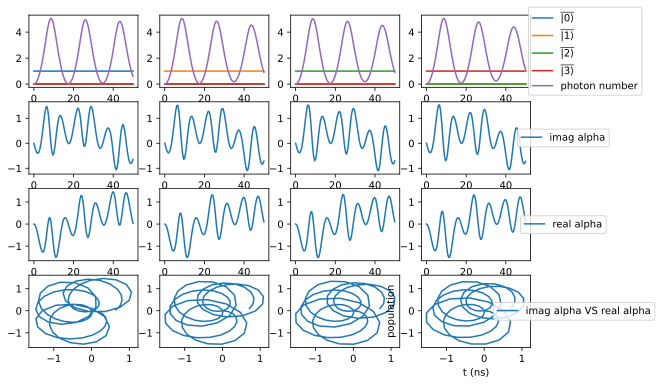

In [163]:

fig, axes = plt.subplots(4,nlevels, figsize=(9, 6))

for i in range(nlevels):
    qubit_state_population = [np.zeros(shape=len(tlist))]*qubit_level
    for idx, product_state in enumerate(product_states):
        ql = product_state[0]
        qubit_state_population[ql] += results[i].expect[idx]
    for ql in range(nlevels):
        axes[0][i].plot(tlist, qubit_state_population[ql], label=r"$\overline{|%s\rangle}$" % (f"{ql}"))
    

    #*np.exp(-1j * 2 * np.pi * first_dominant_freq * tlist) # *np.exp(-1j * 2 * np.pi * dominant_freq * tlist)  

    alpha = results[i].expect[-2]*np.exp(-1j * 2 * np.pi * w_d * tlist)

    # Coherent state eigenval
    real = alpha.real
    imag = alpha.imag
    axes[1][i].plot(tlist,imag , label=r"imag alpha")
    axes[2][i].plot(tlist, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")
    
    # Photon number
    axes[0][i].plot(tlist, results[i].expect[-1], label=r"photon number")


axes[0][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in [0,1,2,3]:
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in range(nlevels):
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in range(nlevels):
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()